An illustration of unsupervised learning of features for images from the Olivetti faces dataset
using the sparse filtering algorithm. This work is based on the paper "Sparse Filtering"
by the authors Jiquan Ngiam, Pang Wei Koh, Zhenghao Chen, Sonia Bhaskar, and Andrew Y. Ng published in NIPS 2011.

The sparse filtering algorithm does not try to model the data's distribution but rather to learn features which
are sparsely activated, in the sense that

 * for each example, only a small subset of features is activated ("Population Sparsity")
 * each feature is only activated on a small subset of he examples ("Lifetime Sparsity")
 * features are roughly activated equally often ("High Dispersal")
 
This sparsity is encoded as an objective function and L-BFGS is used to minimize this
function.

This notebook illustrates the algorithm on the Olivetti faces dataset.

The source code of the sparse-filtering implementation is avalaible at https://github.com/jmetzen/sparse-filtering

In [2]:
import numpy as np
import pylab as plt

np.random.seed(0)
%matplotlib inline

In [3]:
# Install with "pip install sparse_filtering"
from sparse_filtering import SparseFiltering

This will load the Olivetti faces dataset, normalize the examples (global and local centering), and convert each example into a 2D structure (64*64 pixel image). Thereupon, 25 patches of size 16x16pixels are extracted randomly from each image.

In [4]:
from sklearn.datasets import fetch_olivetti_faces
dataset = fetch_olivetti_faces(shuffle=True)
faces = dataset.data

n_samples, _ = faces.shape

faces_centered = faces - faces.mean(axis=0)  # global centering

faces_centered -= \
    faces_centered.mean(axis=1).reshape(n_samples, -1)  # local centering

faces_centered = \
    faces_centered.reshape(n_samples, 64, 64)  # Reshaping to 64*64 pixel images
    
plt.imshow(faces_centered[0], cmap=plt.get_cmap('gray'))
_ = plt.title("One example from dataset with n=%s example" % n_samples)

In [5]:
# Extract 25 16x16 patches randomly from each image
from sklearn.feature_extraction.image import extract_patches_2d
patch_width = 16

patches = [extract_patches_2d(faces_centered[i], (patch_width, patch_width),
                              max_patches=25, random_state=i)
              for i in range(n_samples)]
patches = np.array(patches).reshape(-1, patch_width * patch_width)

In [6]:
# Show 25 exemplary patches
plt.figure(figsize=(8, 8))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(patches[i].reshape(patch_width, patch_width), cmap=plt.get_cmap('gray'))
    plt.xticks([])
    plt.yticks([])
_ = plt.suptitle("25 exemplary extracted patches")

The Sparse Filtering estimator is trained on entires dataset and 64 features extractors are learned. Note that this is computationally expensive and might take several minutes. After training, the corresponding features are extracted for the whole dataset.

In [7]:
n_features = 64   # How many features are learned
estimator = SparseFiltering(n_features=n_features, 
                            maxfun=200,  # The maximal number of evaluations of the objective function
                            iprint=10)  # after how many function evaluations is information printed
                                        # by L-BFGS. -1 for no information
features = estimator.fit_transform(patches)

The following graphic illustrates the learned feature detectors. Note that most of these correspond to Gabor-like edge detectors, while some seem to correspond to noise. The latter is potentially either because L-BFGS was stopped before convergence or because the number of features (64) was chosen too large.

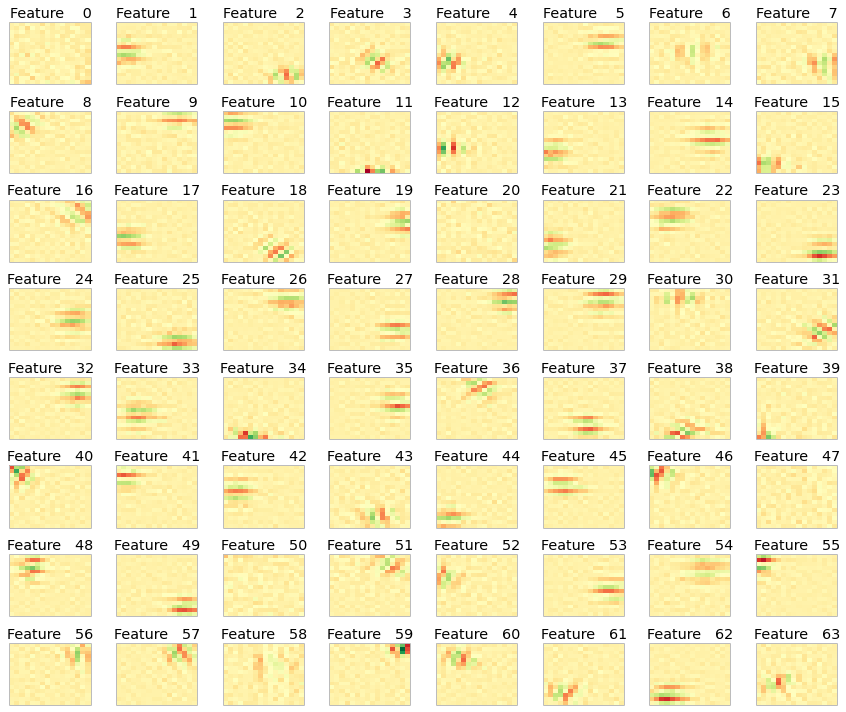

In [8]:
plt.figure(figsize=(12, 10))
for i in range(estimator.w_.shape[0]):
    plt.subplot(int(np.sqrt(n_features)), int(np.sqrt(n_features)), i + 1)
    plt.pcolor(estimator.w_[i].reshape(patch_width, patch_width),
               cmap=plt.cm.RdYlGn, vmin=estimator.w_.min(),
               vmax=estimator.w_.max())
    plt.xticks(())
    plt.yticks(())
    plt.title("Feature %4d" % i)
plt.tight_layout()

Activation histogram
============================

We check if the learned feature extractors have the desired sparsity properties:

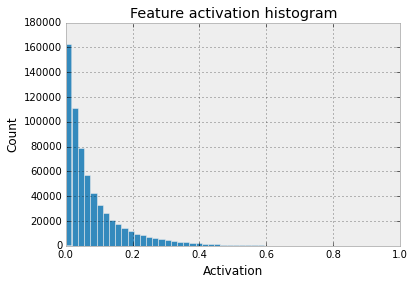

In [9]:
plt.hist(features.flat, bins=50)
plt.xlabel("Activation")
plt.ylabel("Count")
_ = plt.title("Feature activation histogram")

The graphic confirms that features have small activation typically.

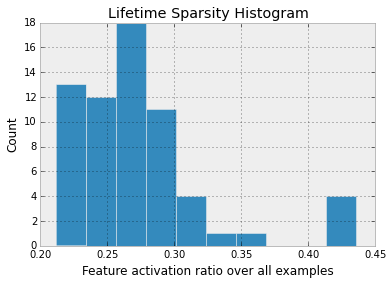

In [10]:
activated_features = (features > 0.1).mean(0)
plt.hist(activated_features)
plt.xlabel("Feature activation ratio over all examples")
plt.ylabel("Count")
_ = plt.title("Lifetime Sparsity Histogram")

**Lifetime Sparsity**: The figure confirms that each feature is only active (i.e., has an activation above 0.1) for a small ratio of the examples (approx. 25%)

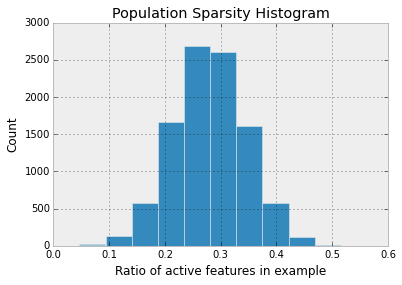

In [11]:
activated_features = (features > 0.1).mean(1)
plt.hist(activated_features, bins=10)
plt.xlabel("Ratio of active features in example")
plt.ylabel("Count")
_ = plt.title("Population Sparsity Histogram")

**Population Sparsity**: Each example activates only few features (approx. 25-30% of the features)

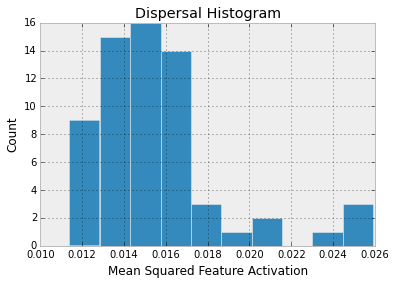

In [12]:
plt.hist((features**2).mean(0))
plt.xlabel("Mean Squared Feature Activation")
plt.ylabel("Count")
_ = plt.title("Dispersal Histogram")

**High Dispersal**: All features have similar statistics; no one feature has significantly more “activity” than the other features. This is checked by plotting the mean squared activations of each feature obtained by averaging
the squared values in the feature matrix across the examples.

Learning a second layer of features using greedy layer-wise stacking on the features produced by the first layer.

In [13]:
n_features2 = 10   # How many features are learned
estimator2 = SparseFiltering(n_features=n_features2, 
                             maxfun=200,  # The maximal number of evaluations of the objective function
                             iprint=10)  # after how many function evaluations is information printed
                                        # by L-BFGS. -1 for no information
features2 = estimator2.fit_transform(features)

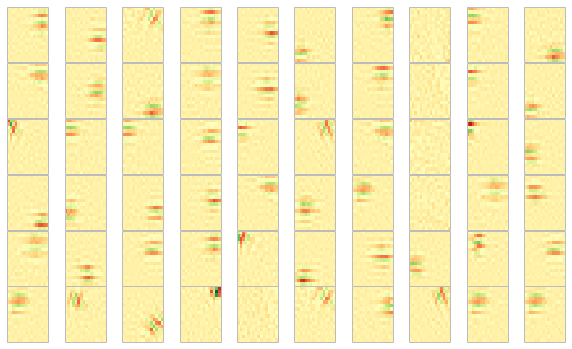

In [14]:
plt.figure(figsize=(10, 6))
for i in range(n_features2):
    # Select the top-6 layer-1 features used within the layer-2 features
    indices = np.argsort(estimator2.w_[i])[-6:][::-1]
    for j, ind in enumerate(indices):
        plt.subplot(6, n_features2, j*n_features2 + i + 1)
        plt.pcolor(estimator.w_[ind].reshape(patch_width, patch_width),"
                   cmap=plt.cm.RdYlGn, vmin=estimator.w_.min(),
                   vmax=estimator.w_.max())
        plt.xticks(())
        plt.yticks(())
plt.subplots_adjust(wspace=0.4, hspace=0.01)

Each column of the graphic shows the top-6 layer-1 feature extractors used within one of the 10 layer-2 features. According to the paper, this "discovers meaningful features that pool the first layer features". This, however, is only partially reproducable on the Olivetti dataset.

In summary

 *  sparse filtering is a unsupervsied feature learning algorithm that does not try to model the data's distribution but rather to learn features directly which are sparsely activated
 * the learned feature extractors obey specific sparsity conditions (lifetime sparsity, population sparsity, and high dispersal)
 * deep archictectures can be trained using greedy layer-wise stacking
 * the only parameter requiring tuning is the number of features per layer
 
 We will analyse the quality of the learned features in a predictive setting in a follow-up post.